In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.style as style

import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm

import scqubits as scq
import qutip as qt
import scipy as sp

from PulseSequence import PulseSequence
from QSwitch import QSwitch

style.use('default')
plt.rcParams['figure.figsize'] = [9.7, 6]
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# scq.settings.PROGRESSBAR_DISABLED = True

In [2]:
hbar = 1.054e-34
h = hbar*2*np.pi
qe = 1.602e-19
red_flux_quant = hbar/2/qe 

# Unit conversions
MHz = 10.0**(-3)
GHz = 1.0
kHz = 10.0**(-6)
us = 10.0**3
ns = 1.0

# Set qubit parameters

In [20]:
# q_in, q_switch eg->gf

# EJs = [13.41, 12.52]
# ECs = [0.159, 0.183]

# qubit_freqs = [3.646, 4.536]
# alphas = [-0.159, -0.183]
# gs = [0.025]

qubit_freqs = np.array([4146.29086882, 3464.74038527])*1e-3
# ZZs = np.array([[0., 0.], [0., 0.]])
ZZs = np.array([[ 0., -4.71267755], [-4.23607803, 0.]])*1e-3
# ZZs = np.array([[0]*2]*2)

# Analytical swap

In [164]:
cutoffs = [2, 2]
# cutoffs = [4, 5]
isCavity = [False, False]

qram = QSwitch(
    # EJs=EJs,
    # ECs=ECs,
    qubit_freqs=qubit_freqs,
    # alphas=alphas,
    # gs=gs,
    ZZs=-ZZs,
    useZZs=True,
    cutoffs=cutoffs,
    is2Q=True,
    isCavity=isCavity,
)

qubit_freqs = qram.qubit_freqs
alphas = qram.alphas
print('qubit freqs (GHz)', *qubit_freqs)
print('alphas (GHz)', *alphas)

# print('capacitances (fF)', *(qe**2/(2*h*np.array(qram.ECs)*1e9)*1e15))
# print('lumped L (nH)', *(red_flux_quant**2/h/np.array(qram.EJs)))

qram.H.eigenenergies()

qubit freqs (GHz) 4.1462908688199995 3.46474038527
alphas (GHz) 0 0


array([ 0.        , 21.76960588, 26.05191387, 47.84963309])

## Create pulse sequence

In [230]:
seq = PulseSequence(start_time=0)

# print('wd1')
# wd = qram.add_sequential_pi_pulse(seq, 'eg', 'gf', amp=0.12, drive_qubit=1)
# analytical_sideband = 2*qubit_freqs[1]+alphas[1]-qubit_freqs[0]
# print(f'Necessary drive frequency [MHz]: {1e3*wd/2/np.pi} vs. analytical: {1e3*analytical_sideband}: difference is [MHz] {(analytical_sideband - wd/2/np.pi)*1e3}')
# print('Done.', flush=True)

sigma_n = 4

# def amp_eff(sigma_ns, sigma_n=sigma_n):
#     # return 1/(4*sigma_ns) * np.sqrt(2) # multiply x sqrt(2) to convert from rabi rate to eff amp for a+a^dag, divide by 4 to convert pi/2 pulse to 2*pi pulse
#     # sigma_n = total number of sigmas
#     return 1/4 / (sigma_ns * np.sqrt(2*np.pi) * sp.special.erf(sigma_n/2 / np.sqrt(2)))

    # pulse1_s_len, pulse1_s_amp, pulse1_s_phase = sigma_n*sigma_length, pulse1_amp*sqrt(2*pi)/2/sigma_n*special.erf(sqrt(2)/2*sigma_n), pulse1_phase
# new_state = 'eg'
# pulse_sigma = 39.52752976190476
# amp = amp_eff(pulse_sigma)
# drive_qubit = 0
# phase_rad = np.pi/2
# wd = 2*np.pi*4.146290868817749
def amp_eff(len_ns):
    # return 1/(4*sigma_ns) * np.sqrt(2) # multiply x sqrt(2) to convert from rabi rate to eff amp for a+a^dag, divide by 4 to convert pi/2 pulse to 2*pi pulse
    # sigma_n = total number of sigmas
    return 1/4 / len_ns

# # t_pulse = qram.get_Tpi('gg', new_state, amp=2*amp, drive_qubit=drive_qubit)
# qram.add_precise_pi_pulse(seq, 'gg', new_state, wd=wd, amp=amp, drive_qubit=drive_qubit, phase=phase_rad, type='gauss', t_offset=0, t_pulse=pulse_sigma)


new_state = 'eg'
pulse_sigma = 39.52752976190476*3
amp = amp_eff(pulse_sigma)
# amp = 0.0026434712259577457
drive_qubit = 0
phase_rad = np.pi/2
wd = 2*np.pi*4.146290868817749

# t_pulse = qram.get_Tpi('gg', new_state, amp=2*amp, drive_qubit=drive_qubit)
qram.add_precise_pi_pulse(seq, 'gg', new_state, wd=wd, amp=amp, drive_qubit=drive_qubit, phase=phase_rad, type='const', t_offset=0, t_pulse=pulse_sigma, sigma_n=sigma_n)

# new_state = 'ge'
# pulse_sigma = 20.032051282051285
# amp = amp_eff(pulse_sigma)
# # amp = 0.005216135186934479
# drive_qubit = 1
# # phase_rad = -np.pi/2
# phase_rad = 1.5707963267948966
# wd = 2*np.pi*3.4647403852710683

# # t_pulse = qram.get_Tpi('gg', new_state, amp=2*amp, drive_qubit=drive_qubit)
# qram.add_precise_pi_pulse(seq, 'gg', new_state, wd=wd, amp=amp, drive_qubit=drive_qubit, phase=phase_rad, type='gauss', t_offset=0, t_pulse=pulse_sigma, sigma_n=sigma_n)


26.05191386624856

[4.146290868817749] (GHz)
[118.58258928571428] (ns)
total pulse length 118.58258928571428 ns
238


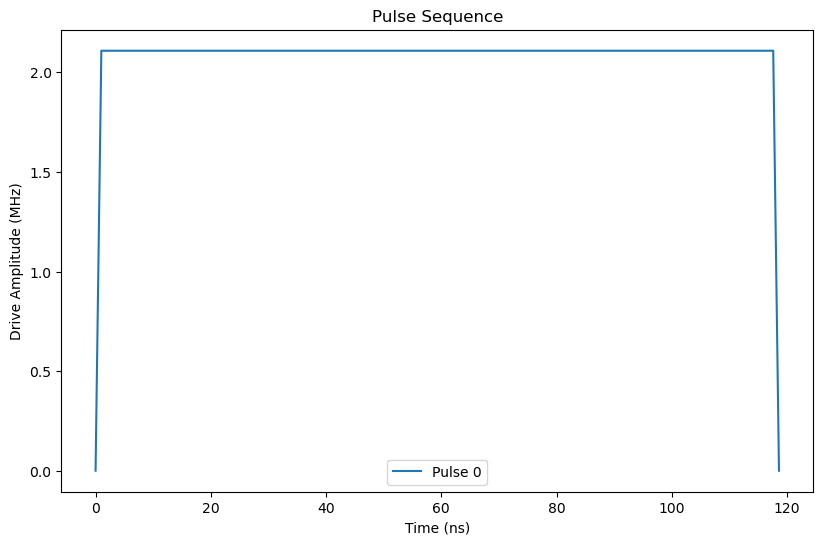

In [231]:

envelope_seq = seq.get_envelope_seq()
pulse_amps = seq.get_pulse_amps()
print(seq.get_pulse_freqs(), '(GHz)')
print(seq.get_pulse_lengths(), '(ns)')
print('total pulse length', sum(seq.get_pulse_lengths()), 'ns')

# times = np.linspace(0, 500, 500)
# times = np.linspace(0, 2500, 1000)
nsteps = int(sum(seq.get_pulse_lengths())//0.5 + 1)
print(nsteps)
times = np.linspace(0, sum(seq.get_pulse_lengths()), num=nsteps)

for i in range(len(envelope_seq)):
    plt.plot(times, [pulse_amps[i]*envelope_seq[i](t)/MHz for t in times], label=f'Pulse {i}')
plt.xlabel('Time (ns)')
plt.ylabel('Drive Amplitude (MHz)')
plt.title('Pulse Sequence')
plt.legend()
plt.show()

# tstart = seq.get_pulse_lengths()[0]
# seq.pulse_seq[1](tstart, None)/pulse_amps[1]/envelope_seq[1](tstart)

## Run simulation

In [232]:
labframe = True
T1 = 60e3 # ns
T2 = 30e3 # ?

# T1 = 10e3

# c_ops = [
#     np.sqrt(1/T1)*qram.a,
#     np.sqrt(1/T1)*qram.b,
# ]

c_ops = None

In [233]:
# psi0_name = 'eggg'
# psi0_name = 'gfgg'
# psi0_name = 'efgg'
# psi0_name = 'eegg'
# psi0_name = 'ggeg'
# psi0_name = 'ggge'
# psi0 = qram.state(psi0_name)

psi0 = qram.state('gg')
# psi0 = np.sqrt(0.5) * (qram.state('gg') + qram.state('eg'))
# psi0 = np.sqrt(0.25) * qram.state('gf') + np.sqrt(0.75) * qram.state('eg') # QRAM start
# psi0 = np.sqrt(0.25) * qram.state('eggg') + np.sqrt(0.75) * qram.state('eegg') # QRAM start
# psi0 = np.sqrt(0.25) * qram.state('gggg') + np.sqrt(0.75) * qram.state('gegg') # QRAM start

start_time = time.time()

print('Simulation in lab frame:', labframe)
if labframe:
    result = qram.evolve(psi0=psi0, seq=seq, times=times, c_ops=None, use_str_solve=False, nsteps=100000)
else:
    result = qram.evolve_rot_frame(psi0=psi0, seq=seq, times=times, nsteps=100000, c_ops=None)
print("Run time (s):", time.time() - start_time, flush=True)

Simulation in lab frame: True
10.1%. Run time:   0.05s. Est. time left: 00:00:00:00
20.2%. Run time:   0.11s. Est. time left: 00:00:00:00
30.3%. Run time:   0.16s. Est. time left: 00:00:00:00
40.3%. Run time:   0.22s. Est. time left: 00:00:00:00
50.0%. Run time:   0.27s. Est. time left: 00:00:00:00
60.1%. Run time:   0.32s. Est. time left: 00:00:00:00
70.2%. Run time:   0.36s. Est. time left: 00:00:00:00
80.3%. Run time:   0.42s. Est. time left: 00:00:00:00
90.3%. Run time:   0.47s. Est. time left: 00:00:00:00
Total run time:   0.51s
Run time (s): 0.5189962387084961


gg probabilty 0.5089180086508299
ge probabilty 0.0
eg probabilty 0.4910819913491703
ee probabilty 0.0


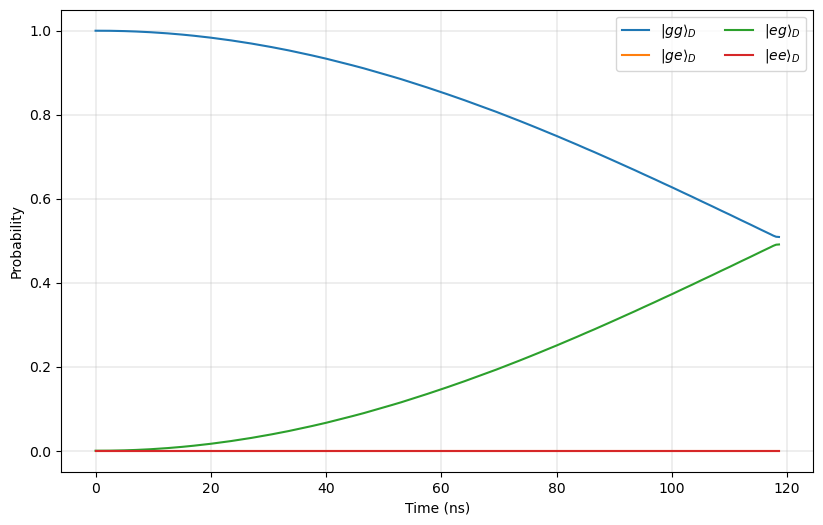

In [234]:
ref_states = ['gg', 'ge', 'eg', 'ee']
# ref_states = ['gg', 'ge']
# ref_states = ['eg', 'gf', 'gg']
for ref_state in ref_states:
    state = qram.state(ref_state)
    # state = psi0
    probs = [np.abs(state.overlap(result[t]))**2 for t in range(len(times))]
    print(ref_state, 'probabilty', probs[-1])
    plt.plot(times, probs, label=f'$|{ref_state}\\rangle_D$')

# plt.plot(times, [0.5]*len(times), 'k--', linewidth=0.5)
plt.legend(ncol=2)
plt.ylim(-0.05, 1.05)
# plt.xlim(750, 1000)
# plt.tick_params(labelsize=12)
plt.xlabel('Time (ns)')
plt.ylabel('Probability')
# plt.title(r'$\psi_0=|$'+psi0_name+r'$\rangle$')
# plt.title('QRAM state evolution in memory access operation')
plt.grid(linewidth=0.3)
# plt.vlines([124], ymin=0, ymax=1)
plt.show()

In [10]:
print(result[-1])

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[ 0.35334444-0.35232387j]
 [ 0.49823309-0.02504736j]
 [-0.13240812+0.48694768j]
 [-0.41539295+0.27377135j]]


In [11]:
ref_state = qram.state()
probs = [np.abs(state.overlap(result[t]))**2 for t in range(len(times))]
print(ref_state, 'probabilty', probs[-1])
plt.plot(times, probs, label=f'$|{ref_state}\\rangle_D$')

TypeError: state() missing 1 required positional argument: 'levels'